In [622]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import time

plt.style.use('ggplot')

讀取台指期以及轉倉日資料、並進行預處理
=

In [623]:
df = pd.read_csv('TWF_Futures_Minute_Trade.txt')
df

,Date,Time,Open,High,Low,Close,TotalVolume
0,2009/1/5,08:46:00,4722.0,4745.0,4714.0,4727.0,1493
1,2009/1/5,08:47:00,4727.0,4728.0,4711.0,4716.0,608
2,2009/1/5,08:48:00,4713.0,4720.0,4713.0,4716.0,400
3,2009/1/5,08:49:00,4717.0,4722.0,4715.0,4718.0,457
4,2009/1/5,08:50:00,4719.0,4721.0,4718.0,4719.0,233
...,...,...,...,...,...,...,...
1971251,2022/5/23,09:10:00,16210.0,16216.0,16206.0,16214.0,452
1971252,2022/5/23,09:11:00,16215.0,16215.0,16207.0,16210.0,224
1971253,2022/5/23,09:12:00,16210.0,16220.0,16207.0,16218.0,478
1971254,2022/5/23,09:13:00,16218.0,16220.0,16212.0,16218.0,240


In [624]:
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour)
df

,open,high,low,close,volume,Hour
2009-01-05 08:46:00,4722.0,4745.0,4714.0,4727.0,1493,8
2009-01-05 08:47:00,4727.0,4728.0,4711.0,4716.0,608,8
2009-01-05 08:48:00,4713.0,4720.0,4713.0,4716.0,400,8
2009-01-05 08:49:00,4717.0,4722.0,4715.0,4718.0,457,8
2009-01-05 08:50:00,4719.0,4721.0,4718.0,4719.0,233,8
...,...,...,...,...,...,...
2022-05-23 09:10:00,16210.0,16216.0,16206.0,16214.0,452,9
2022-05-23 09:11:00,16215.0,16215.0,16207.0,16210.0,224,9
2022-05-23 09:12:00,16210.0,16220.0,16207.0,16218.0,478,9
2022-05-23 09:13:00,16218.0,16220.0,16212.0,16218.0,240,9


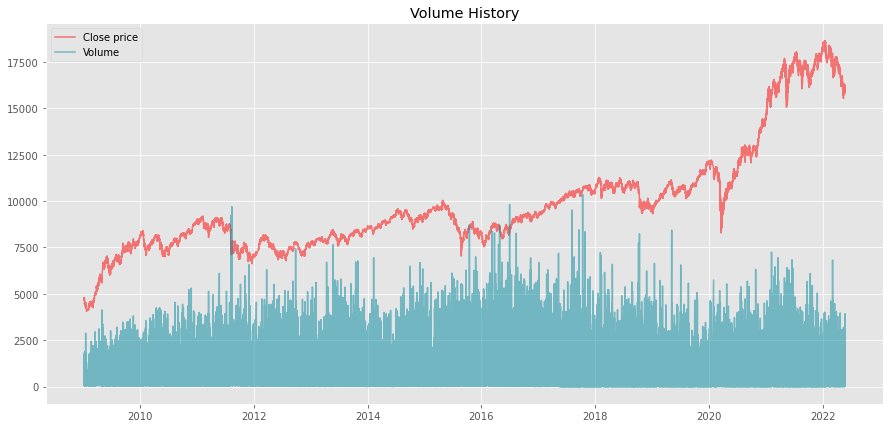

In [625]:
plt.figure(figsize = (15,7))
plt.plot(df['close'], color = 'red', alpha = 0.5, label = 'Close price')
plt.plot(df['volume'], color = '#01889f', alpha = 0.5, label = 'Volume')
plt.legend(loc='upper left')
plt.title('Volume History');

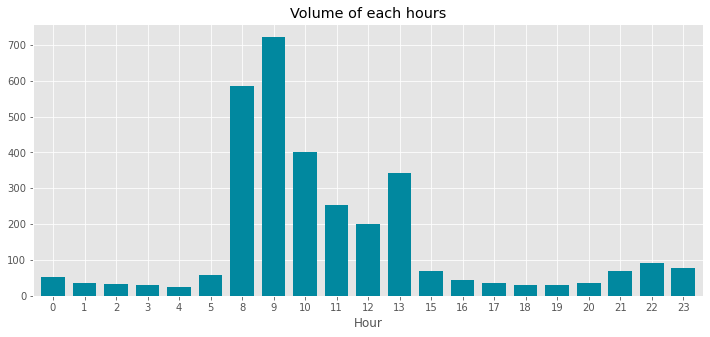

In [626]:
data = df[(df.index >= '2017-05-15 00:00:00')].copy()
plt.figure(figsize = (12,5))
data.groupby(['Hour'])['volume'].mean().plot(kind='bar', width=0.75, color='#01889f')
plt.xticks(rotation = 0)
plt.title('Volume of each hours');

In [627]:
#三分K
rule = '3T'

Morning = df[(df['Hour'] >= 8) & (df['Hour'] <= 13)]
Morning.index = Morning.index + dt.timedelta(minutes=15)

d1 = Morning.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Morning.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Morning.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Morning.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Morning.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Morning = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Morning = df_Morning.dropna()
df_Morning.index = df_Morning.index - dt.timedelta(minutes=15)
df_Morning.head()

,open,high,low,close,volume
2009-01-05 08:45:00,4722.0,4745.0,4711.0,4716.0,2501
2009-01-05 08:48:00,4717.0,4725.0,4715.0,4719.0,1009
2009-01-05 08:51:00,4721.0,4722.0,4707.0,4712.0,973
2009-01-05 08:54:00,4713.0,4716.0,4705.0,4713.0,627
2009-01-05 08:57:00,4713.0,4720.0,4711.0,4714.0,673


In [628]:
rule = '3T'

Night = df[(df['Hour'] < 8) | (df['Hour'] > 13)]

d1 = Night.resample(rule=rule, closed='right', label='left').first()[['open']]
d2 = Night.resample(rule=rule, closed='right', label='left').max()[['high']]
d3 = Night.resample(rule=rule, closed='right', label='left').min()[['low']]
d4 = Night.resample(rule=rule, closed='right', label='left').last()[['close']]
d5 = Night.resample(rule=rule, closed='right', label='left').sum()[['volume']]

df_Night = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_Night = df_Night.dropna()
df_Night.head()

,open,high,low,close,volume
2017-05-15 15:00:00,10023.0,10033.0,10023.0,10032.0,258
2017-05-15 15:03:00,10032.0,10032.0,10020.0,10029.0,109
2017-05-15 15:06:00,10029.0,10030.0,10028.0,10028.0,27
2017-05-15 15:09:00,10028.0,10029.0,10022.0,10023.0,122
2017-05-15 15:12:00,10024.0,10024.0,10020.0,10023.0,59


In [629]:
df_Day = pd.concat([df_Morning, df_Night], axis=0)
df_Day = df_Day.sort_index(ascending=True)
df_Day.head()

,open,high,low,close,volume
2009-01-05 08:45:00,4722.0,4745.0,4711.0,4716.0,2501
2009-01-05 08:48:00,4717.0,4725.0,4715.0,4719.0,1009
2009-01-05 08:51:00,4721.0,4722.0,4707.0,4712.0,973
2009-01-05 08:54:00,4713.0,4716.0,4705.0,4713.0,627
2009-01-05 08:57:00,4713.0,4720.0,4711.0,4714.0,673


In [630]:
df_Morning['Hour'] = df_Morning.index.map(lambda x: x.hour)
trainData = df_Morning[(df_Morning.index >= '2011-01-01 00:00:00') & (df_Morning.index <= '2019-12-31 00:00:00')].copy()
testData = df_Morning[(df_Morning.index >= '2020-1-1 00:00:00') & (df_Morning.index <= '2022-5-22 00:00:00')].copy()

In [631]:
trainData.head(3)


,open,high,low,close,volume,Hour
2011-01-03 08:45:00,9000.0,9009.0,8995.0,9009.0,2190,8
2011-01-03 08:48:00,9009.0,9015.0,9005.0,9011.0,1615,8
2011-01-03 08:51:00,9012.0,9019.0,9011.0,9015.0,982,8


In [632]:
testData.tail(3)

,open,high,low,close,volume,Hour
2022-05-20 13:36:00,16128.0,16133.0,16125.0,16132.0,642,13
2022-05-20 13:39:00,16133.0,16135.0,16126.0,16129.0,1250,13
2022-05-20 13:42:00,16129.0,16142.0,16127.0,16135.0,2044,13


In [633]:
settlementDate_ = pd.read_csv('settlementDate.csv')
settlementDate_.columns = ['settlementDate', 'futures', 'settlementPrice']
settlementDate_

,settlementDate,futures,settlementPrice
0,2022/08/03,202208W1,14707
1,2022/07/27,202207W4,14887
2,2022/07/20,202207,14713
3,2022/07/13,202207W2,14384
4,2022/07/06,202207W1,14015
...,...,...,...
508,2009/12/16,200912,7752
509,2009/11/18,200911,7786
510,2009/10/21,200910,7705
511,2009/09/16,200909,7445


In [634]:
bool_ = [False if 'W' in i else True for i in settlementDate_['futures']]

In [635]:
settlementDate = [i.replace('/','-') for i in list(settlementDate_[bool_]['settlementDate'])]

In [636]:
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]

In [637]:
settlementDate

[datetime.date(2022, 7, 20),
 datetime.date(2022, 6, 15),
 datetime.date(2022, 5, 18),
 datetime.date(2022, 4, 20),
 datetime.date(2022, 3, 16),
 datetime.date(2022, 2, 16),
 datetime.date(2022, 1, 19),
 datetime.date(2021, 12, 15),
 datetime.date(2021, 11, 17),
 datetime.date(2021, 10, 20),
 datetime.date(2021, 9, 15),
 datetime.date(2021, 8, 18),
 datetime.date(2021, 7, 21),
 datetime.date(2021, 6, 16),
 datetime.date(2021, 5, 19),
 datetime.date(2021, 4, 21),
 datetime.date(2021, 3, 17),
 datetime.date(2021, 2, 17),
 datetime.date(2021, 1, 20),
 datetime.date(2020, 12, 16),
 datetime.date(2020, 11, 18),
 datetime.date(2020, 10, 21),
 datetime.date(2020, 9, 16),
 datetime.date(2020, 8, 19),
 datetime.date(2020, 7, 15),
 datetime.date(2020, 6, 17),
 datetime.date(2020, 5, 20),
 datetime.date(2020, 4, 15),
 datetime.date(2020, 3, 18),
 datetime.date(2020, 2, 19),
 datetime.date(2020, 1, 15),
 datetime.date(2019, 12, 18),
 datetime.date(2019, 11, 20),
 datetime.date(2019, 10, 16),
 date

以台指期3分K進行回測

In [638]:
fund = 1000000
feePaid = 600 #交易成本
K = 0.2

In [639]:
#計算KD線
'''
1.計算RSV:(今日收盤價-最近9天的最低價)/(最近9天的最高價-最近9天的最低價) *100
2.計算K: K = 2/3 X (昨日K值) + 1/3 X (今日RSV)
3.:計算D: D = 2/3 X (昨日D值) + 1/3 X (今日K值)
'''
def KD(data):
    df = data.copy()
    df['min'] = df['low'].rolling(9).min()
    df['max'] = df['high'].rolling(9).max()
    df['RSV'] = (df['close'] - df['min'])/(df['max'] - df['min']) *100
    df = df.dropna()
    # 計算K
    # K的初始值定為50
    K_list = [50]
    for num,rsv in enumerate(list(df['RSV'])):
        K_yestarday = K_list[num]
        K_today = 2/3 * K_yestarday + 1/3 * rsv
        K_list.append(K_today)
    df['K'] = K_list[1:]
    # 計算D
    # D的初始值定為50
    D_list = [50]
    for num,K in enumerate(list(df['K'])):
        D_yestarday = D_list[num]
        D_today = 2/3 * D_yestarday + 1/3 * K
        D_list.append(D_today)
    df['D'] = D_list[1:]
    use_df = pd.merge(data,df[['K','D']],left_index=True,right_index=True,how='left')
    return use_df

In [640]:
trainData = KD(trainData)
trainData['trend'] = np.where(trainData['K'] > trainData['D'], 1, -1)

In [641]:
trainData

,open,high,low,close,volume,Hour,K,D,trend
2011-01-03 08:45:00,9000.0,9009.0,8995.0,9009.0,2190,8,NaN,NaN,-1
2011-01-03 08:48:00,9009.0,9015.0,9005.0,9011.0,1615,8,NaN,NaN,-1
2011-01-03 08:51:00,9012.0,9019.0,9011.0,9015.0,982,8,NaN,NaN,-1
2011-01-03 08:54:00,9014.0,9018.0,9014.0,9016.0,436,8,NaN,NaN,-1
2011-01-03 08:57:00,9016.0,9017.0,9013.0,9014.0,489,8,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...
2019-12-30 13:30:00,12072.0,12073.0,12070.0,12073.0,846,13,32.238433,26.922636,1
2019-12-30 13:33:00,12072.0,12076.0,12071.0,12073.0,652,13,40.539907,31.461727,1
2019-12-30 13:36:00,12072.0,12074.0,12071.0,12072.0,390,13,39.147817,34.023757,1
2019-12-30 13:39:00,12071.0,12072.0,12068.0,12070.0,917,13,32.159151,33.402221,-1


In [642]:
n_trainData = trainData
trainData = n_trainData[8:]

In [643]:
#將資料建立為陣列提升資料運算的速度
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]
#建立串列來記錄每筆交易
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []


                        profit   profitfee
2011-01-03 09:09:00        0.0         0.0
2011-01-03 09:12:00        0.0         0.0
2011-01-03 09:15:00        0.0         0.0
2011-01-03 09:18:00        0.0         0.0
2011-01-03 09:21:00        0.0         0.0
...                        ...         ...
2019-12-30 13:30:00  1517800.0 -19945400.0
2019-12-30 13:33:00  1517800.0 -19945400.0
2019-12-30 13:36:00  1517800.0 -19945400.0
2019-12-30 13:39:00  1517600.0 -19945600.0
2019-12-30 13:42:00  1517400.0 -19947000.0

[220687 rows x 2 columns]


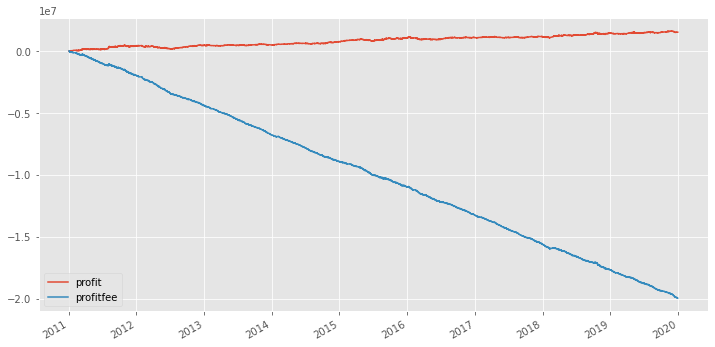

In [644]:
for i in range(len(df_arr)):
    
    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = df_arr[i-1, 8] < df_arr[i, 8]
    entrySellShort = df_arr[i-1, 8] > df_arr[i, 8]
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = df_arr[i-1, 8] > df_arr[i, 8]
    exitBuyToCover = df_arr[i-1, 8] < df_arr[i, 8]
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)


    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));


In [645]:
#profit and drawdown 分析
def profit_and_drawdown():
    equity['equity'] = equity['profitfee'] + fund
    equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
    equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
    fig, ax = plt.subplots(figsize = (16,6))
    high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
    equity['profitfee'].plot(label = 'Total Profit', ax = ax, c = 'r', grid=True)
    plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor  = 'r', label = 'Drawdown', alpha=0.5)
    plt.scatter(high_index, equity['profitfee'].loc[high_index],c = '#02ff0f', label = 'High')

    plt.legend()
    plt.ylabel('Accumulated Profit')
    plt.xlabel('Time')
    plt.title('Profit & Drawdown',fontsize  = 16);

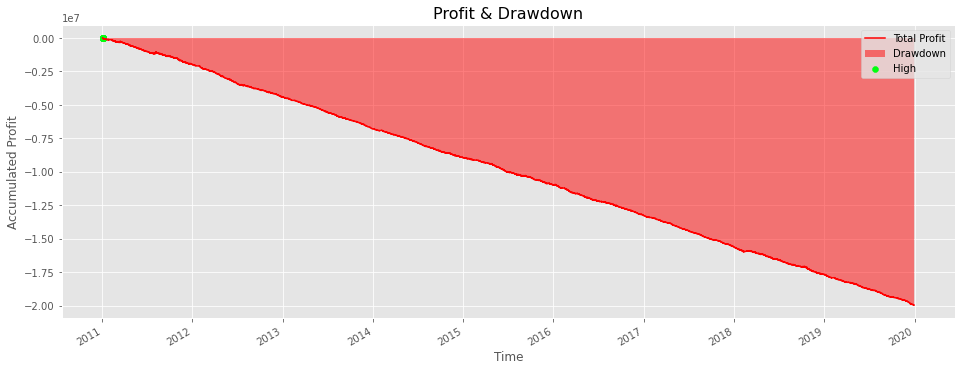

In [646]:
profit_and_drawdown()

In [647]:
def price_movement(data):
    fig, ax = plt.subplots(figsize = (16,6))
    data['close'].plot(label = 'Close Price', ax = ax, c = 'gray', grid=True, alpha=0.8)
    plt.scatter(data['close'].iloc[buy].index, data['close'].iloc[buy],c = 'orangered', label = 'Buy', marker='^', s=60)
    plt.scatter(data['close'].iloc[sell].index, data['close'].iloc[sell],c = 'orangered', label = 'Sell', marker='v', s=60)
    plt.scatter(data['close'].iloc[sellshort].index, data['close'].iloc[sellshort],c = 'limegreen', label = 'Sellshort', marker='v', s=60)
    plt.scatter(data['close'].iloc[buytocover].index, data['close'].iloc[buytocover],c = 'limegreen', label = 'Buytocover', marker='^', s=60)
    plt.legend()
    plt.ylabel('USD')
    plt.xlabel('Time')
    plt.title('Price Movement',fontsize  = 16);

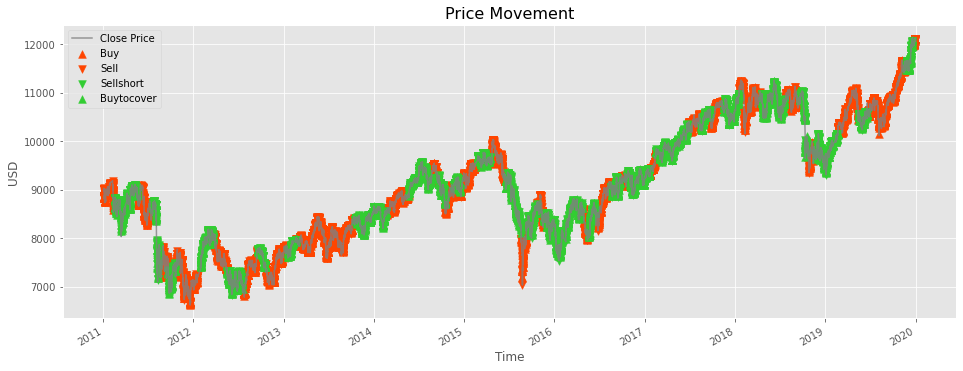

In [648]:
price_movement(trainData)

In [649]:
#統計交易次數
def stat(buy, sell , sellshort, buytocover):
    data = {
        'buy': len(buy),
        'sell': len(sell),
        'sellshort':len(sellshort),
        'buytocover':len(buytocover)
    }
    df = df = pd.DataFrame([data])
    return df

In [650]:
#交易次數
stat(buy, sell , sellshort, buytocover)

,buy,sell,sellshort,buytocover
0,9426,9426,8461,8461


問題 : 交易訊號的出現太過敏感、導致交易次數過多

嘗試加設濾網 : 
黃金交叉時K、D值需同時滿足小於20、死亡交叉K、D值需同時滿足大於80
============================================================

In [651]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

In [652]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

                       profit  profitfee
2011-01-03 09:09:00       0.0        0.0
2011-01-03 09:12:00       0.0        0.0
2011-01-03 09:15:00       0.0        0.0
2011-01-03 09:18:00       0.0        0.0
2011-01-03 09:21:00       0.0        0.0
...                       ...        ...
2019-12-30 13:30:00 -111800.0  -975800.0
2019-12-30 13:33:00 -111800.0  -975800.0
2019-12-30 13:36:00 -111800.0  -975800.0
2019-12-30 13:39:00 -111600.0  -975600.0
2019-12-30 13:42:00 -111400.0  -976600.0

[220687 rows x 2 columns]


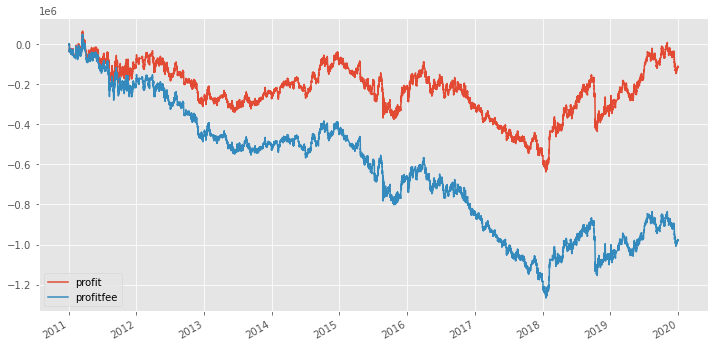

In [653]:
for i in range(len(df_arr)):
    
    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = df_arr[i-1, 8] < df_arr[i, 8] and df_arr[i, 6] < 20 and df_arr[i, 7] < 20
    entrySellShort = df_arr[i-1, 8] > df_arr[i, 8] and df_arr[i, 6] > 80 and df_arr[i, 7] > 80
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = df_arr[i-1, 8] > df_arr[i, 8] and df_arr[i, 6] > 80 and df_arr[i, 7] > 80
    exitBuyToCover = df_arr[i-1, 8] < df_arr[i, 8] and df_arr[i, 6] < 20 and df_arr[i, 7] < 20
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
            

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));


In [654]:
stat(buy, sell , sellshort, buytocover)

,buy,sell,sellshort,buytocover
0,329,329,392,392


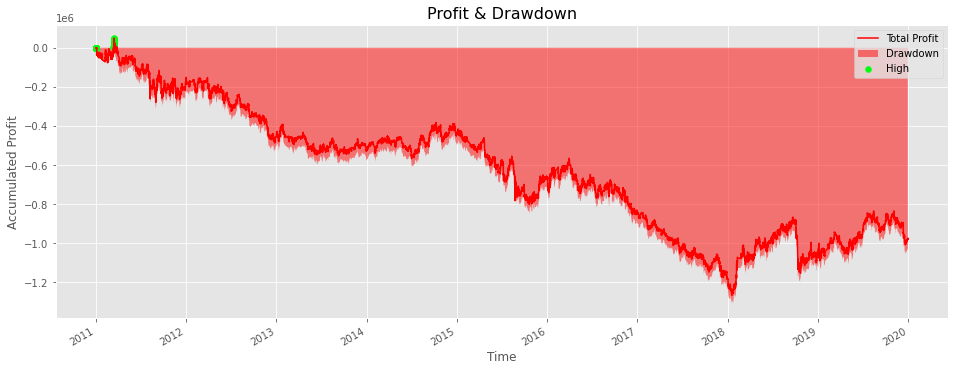

In [655]:
profit_and_drawdown()

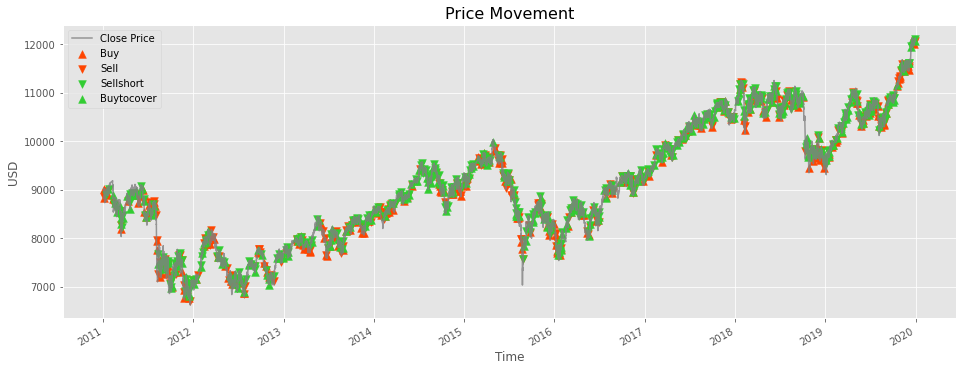

In [656]:
price_movement(trainData)

結果 : 交易次數依然過多，可從上圖看出即使面對到趨勢很明確的上漲或下跌波段，依然會有過多進出場訊號

嘗試再進一步限縮交易模式，從原本可放空(即先賣後買)限縮為只可先買後賣
===============================================================

In [657]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

                       profit  profitfee
2011-01-03 09:09:00       0.0        0.0
2011-01-03 09:12:00       0.0        0.0
2011-01-03 09:15:00       0.0        0.0
2011-01-03 09:18:00       0.0        0.0
2011-01-03 09:21:00       0.0        0.0
...                       ...        ...
2019-12-30 13:30:00  499000.0   -93800.0
2019-12-30 13:33:00  499000.0   -93800.0
2019-12-30 13:36:00  499000.0   -93800.0
2019-12-30 13:39:00  499000.0   -93800.0
2019-12-30 13:42:00  499000.0   -93800.0

[220687 rows x 2 columns]


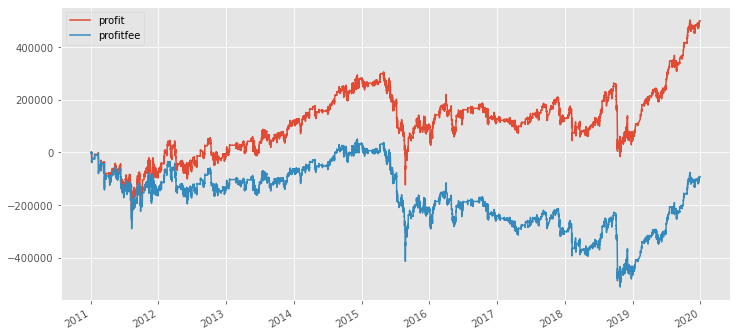

In [658]:
for i in range(len(df_arr)):
    
    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = df_arr[i-1, 8] < df_arr[i, 8] and df_arr[i, 6] < 20 and df_arr[i, 7] < 20
    entrySellShort = df_arr[i-1, 8] > df_arr[i, 8] and df_arr[i, 6] > 80 and df_arr[i, 7] > 80
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = df_arr[i-1, 8] > df_arr[i, 8] and df_arr[i, 6] > 80 and df_arr[i, 7] > 80
    exitBuyToCover = df_arr[i-1, 8] < df_arr[i, 8] and df_arr[i, 6] < 20 and df_arr[i, 7] < 20
    exitCondition = date_arr[i] in settlementDate and df_arr[i,5] >= 11
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            continue
            BS = 'S'
            t = i+1
            sellshort.append(t)
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
    '''
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
        '''    

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));

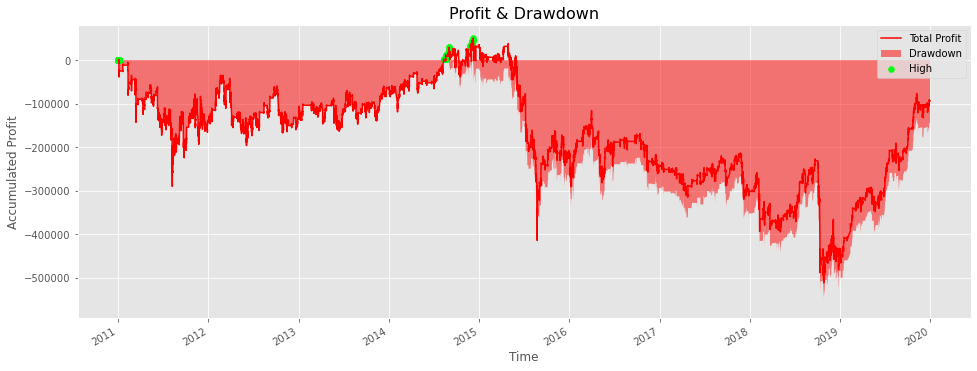

In [659]:
profit_and_drawdown()

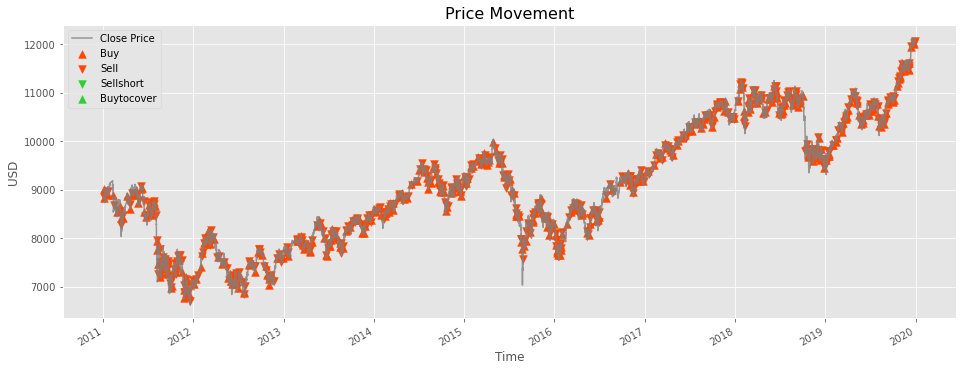

In [660]:
price_movement(trainData)

In [661]:
stat(buy, sell, sellshort, buytocover)

,buy,sell,sellshort,buytocover
0,494,494,0,0


結果 : 獲利情況有所改善，但交易次數太過頻繁的問題依然存在，考慮到加設濾網、限制交易模式都無法有效改善，也許可以改為調整時間尺度的長短

把時間尺度由3分K改為日線、一樣只做先買後賣，但是濾網的設定暫時移除(因為加入K、D值的濾網後交易次數太少)
==========================

In [662]:
df = pd.read_csv('TWF_Futures_Minute_Trade.txt')

In [663]:
df.index = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df = df.drop(columns=['Date','Time'])
df.columns = ['open', 'high', 'low', 'close', 'volume']
df['Hour'] = df.index.map(lambda x: x.hour)

In [664]:
df_day = pd.concat([df_Morning, df_Night], axis=0)
df_day = df_Day.sort_index(ascending=True)
df_day.head()

,open,high,low,close,volume
2009-01-05 08:45:00,4722.0,4745.0,4711.0,4716.0,2501
2009-01-05 08:48:00,4717.0,4725.0,4715.0,4719.0,1009
2009-01-05 08:51:00,4721.0,4722.0,4707.0,4712.0,973
2009-01-05 08:54:00,4713.0,4716.0,4705.0,4713.0,627
2009-01-05 08:57:00,4713.0,4720.0,4711.0,4714.0,673


In [665]:
day = df.loc['2017-5-15':].copy()
df_day.index = df_day.index - dt.timedelta(hours=8)

d1 = df_day.resample(rule='1D', closed='right', label='left').first()[['open']]
d2 = df_day.resample(rule='1D', closed='right', label='left').max()[['high']]
d3 = df_day.resample(rule='1D', closed='right', label='left').min()[['low']]
d4 = df_day.resample(rule='1D', closed='right', label='left').last()[['close']]
d5 = df_day.resample(rule='1D', closed='right', label='left').sum()[['volume']]

df_day = pd.concat([d1,d2,d3,d4,d5], axis=1)
df_day = df_day.dropna()
df_day.index = df_day.index + dt.timedelta(days=1) ##回測時結算日也要加一天
df_day.tail()

,open,high,low,close,volume
2022-05-18,15978.0,16189.0,15963.0,16184.0,125318
2022-05-19,16180.0,16318.0,15889.0,15902.0,125423
2022-05-20,15871.0,16054.0,15748.0,15999.0,224892
2022-05-21,16069.0,16225.0,15852.0,16151.0,199316
2022-05-24,16220.0,16263.0,16204.0,16216.0,17891


In [666]:
trainData = df_day[(df_day.index >= '2011-01-01 00:00:00') & (df_day.index <= '2019-12-31 00:00:00')].copy()
testData = df_day[(df_day.index >= '2020-1-1 00:00:00') & (df_day.index <= '2022-5-22 00:00:00')].copy()

In [667]:
trainData = KD(trainData)
trainData['trend'] = np.where(trainData['K'] > trainData['D'], 1, -1)
trainData = trainData[8:]
testData = KD(testData)
testData['trend'] = np.where(testData['K'] > testData['D'], 1, -1)
testData = testData[8:]

In [668]:
trainData

,open,high,low,close,volume,K,D,trend
2011-01-13,8960.0,9003.0,8945.0,8967.0,82510,59.735974,53.245325,1
2011-01-14,8998.0,9017.0,8916.0,8969.0,107227,66.446645,57.645765,1
2011-01-15,8965.0,8981.0,8931.0,8970.0,67139,71.030436,62.107322,1
2011-01-18,8993.0,9002.0,8914.0,8922.0,93861,69.767417,64.660687,1
2011-01-19,8920.0,9012.0,8871.0,8972.0,103387,74.672531,67.997968,1
...,...,...,...,...,...,...,...,...
2019-12-25,12030.0,12044.0,11958.0,11988.0,69394,77.667017,84.115383,-1
2019-12-26,11989.0,12027.0,11976.0,12017.0,45484,68.218434,78.816400,-1
2019-12-27,12029.0,12042.0,11986.0,12025.0,63660,62.065107,73.232636,-1
2019-12-28,12038.0,12112.0,12037.0,12082.0,92609,66.195579,70.886950,-1


In [669]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

              profit  profitfee
2011-01-13       0.0        0.0
2011-01-14       0.0        0.0
2011-01-15   -6600.0    -6600.0
2011-01-18   -1000.0    -1000.0
2011-01-19  -15600.0   -15600.0
...              ...        ...
2019-12-25  587000.0   362600.0
2019-12-26  587000.0   362600.0
2019-12-27  587000.0   362600.0
2019-12-28  587000.0   362600.0
2019-12-31  587000.0   362600.0

[2203 rows x 2 columns]


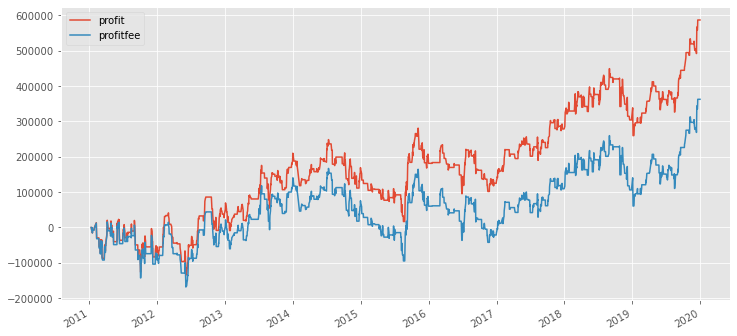

In [670]:

for i in range(len(df_arr)):
    
    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = df_arr[i-1, 7] < df_arr[i, 7] #and df_arr[i, 5] < 0.2 and df_arr[i, 6] < 0.2
    entrySellShort = df_arr[i-1, 7] > df_arr[i, 7] #and df_arr[i, 5] > 0.8 and df_arr[i, 6] > 0.8
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = df_arr[i-1, 7] > df_arr[i, 7] #and df_arr[i, 5] > 0.8 and df_arr[i, 6] > 0.8
    exitBuyToCover = df_arr[i-1, 7] < df_arr[i, 7] #and df_arr[i, 5] < 0.2 and df_arr[i, 6] < 0.2
    exitCondition = date_arr[i] in settlementDate #and df_arr[i, 5] >= 11
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            continue
            BS = 'S'
            t = i+1
            sellshort.append(t)
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
    '''
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
    '''
equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));

In [671]:
stat(buy , sell ,sellshort, buytocover)

,buy,sell,sellshort,buytocover
0,187,187,0,0


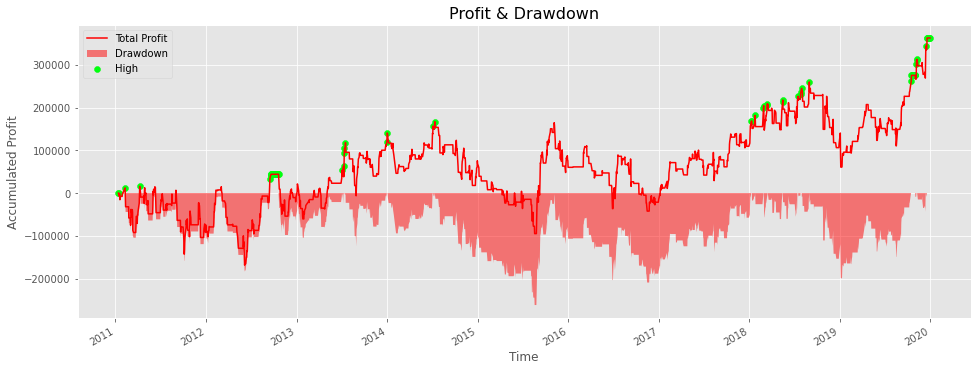

In [672]:
profit_and_drawdown()

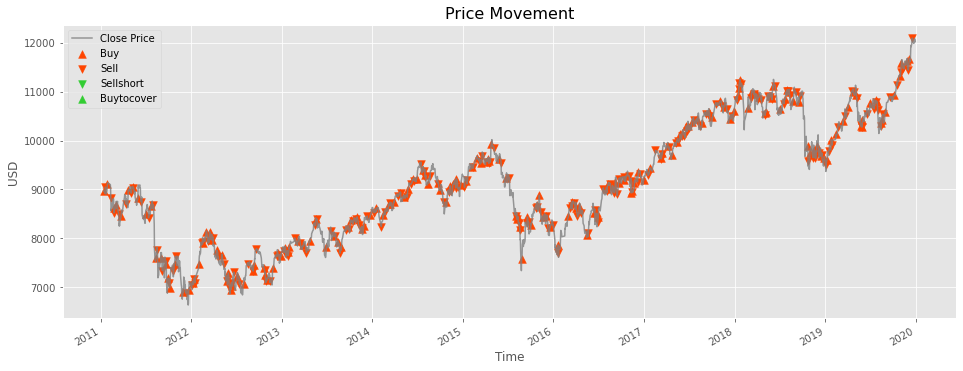

In [673]:
price_movement(trainData)

結果 : 交易頻率、獲利表現均有大幅改善

延續前例，以K、D值於黃金交叉時小於20、死亡交叉時大於80做為濾網，交易次數會過少，但又不想要就此直接捨棄，因此嘗試對K、D值的設定做樣本內的最佳化
====

In [674]:
df_arr = np.array(trainData)
time_arr = np.array(trainData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

In [675]:
trainData

,open,high,low,close,volume,K,D,trend
2011-01-13,8960.0,9003.0,8945.0,8967.0,82510,59.735974,53.245325,1
2011-01-14,8998.0,9017.0,8916.0,8969.0,107227,66.446645,57.645765,1
2011-01-15,8965.0,8981.0,8931.0,8970.0,67139,71.030436,62.107322,1
2011-01-18,8993.0,9002.0,8914.0,8922.0,93861,69.767417,64.660687,1
2011-01-19,8920.0,9012.0,8871.0,8972.0,103387,74.672531,67.997968,1
...,...,...,...,...,...,...,...,...
2019-12-25,12030.0,12044.0,11958.0,11988.0,69394,77.667017,84.115383,-1
2019-12-26,11989.0,12027.0,11976.0,12017.0,45484,68.218434,78.816400,-1
2019-12-27,12029.0,12042.0,11986.0,12025.0,63660,62.065107,73.232636,-1
2019-12-28,12038.0,12112.0,12037.0,12082.0,92609,66.195579,70.886950,-1


----------
KD_low: 15
KD_high: 65
ret: 0.16300000000000003
calmarRatio: 4.352100000000003
   buy  sell  sellshort  buytocover
0    3     3          0           0
----------
KD_low: 15
KD_high: 70
ret: 0.16300000000000003
calmarRatio: 4.352100000000003
   buy  sell  sellshort  buytocover
0    3     3          0           0
----------
KD_low: 15
KD_high: 75
ret: 0.16300000000000003
calmarRatio: 4.352100000000003
   buy  sell  sellshort  buytocover
0    3     3          0           0
----------
KD_low: 15
KD_high: 80
ret: 0.16300000000000003
calmarRatio: 4.352100000000003
   buy  sell  sellshort  buytocover
0    3     3          0           0
----------
KD_low: 15
KD_high: 85
ret: 0.16300000000000003
calmarRatio: 4.352100000000003
   buy  sell  sellshort  buytocover
0    3     3          0           0
----------
KD_low: 20
KD_high: 65
ret: 0.08440000000000003
calmarRatio: 0.5315030599755205
   buy  sell  sellshort  buytocover
0   10    10          0           0
----------
KD_low: 20
KD_hi

c:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


ret: 0.1117999999999999
calmarRatio: 0.4435796453353889
   buy  sell  sellshort  buytocover
0   48    48          0           0
----------
KD_low: 35
KD_high: 75
ret: 0.1117999999999999
calmarRatio: 0.4435796453353889
   buy  sell  sellshort  buytocover
0   48    48          0           0
----------
KD_low: 35
KD_high: 80
ret: 0.1117999999999999
calmarRatio: 0.4435796453353889
   buy  sell  sellshort  buytocover
0   48    48          0           0
----------
KD_low: 35
KD_high: 85
ret: 0.1117999999999999
calmarRatio: 0.4435796453353889
   buy  sell  sellshort  buytocover
0   48    48          0           0


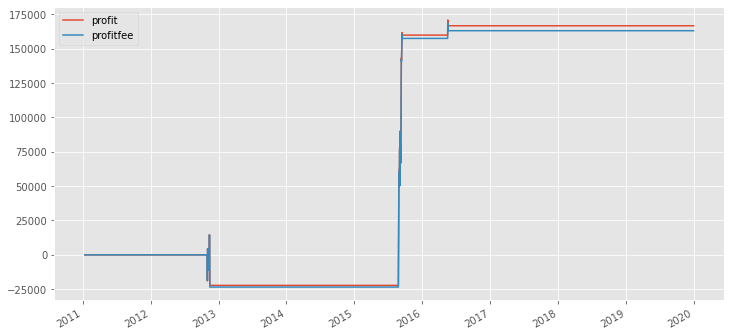

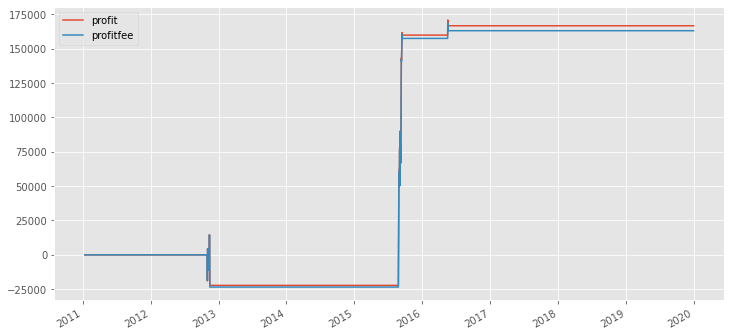

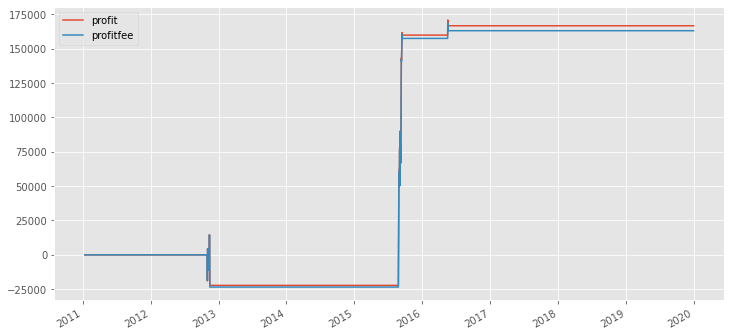

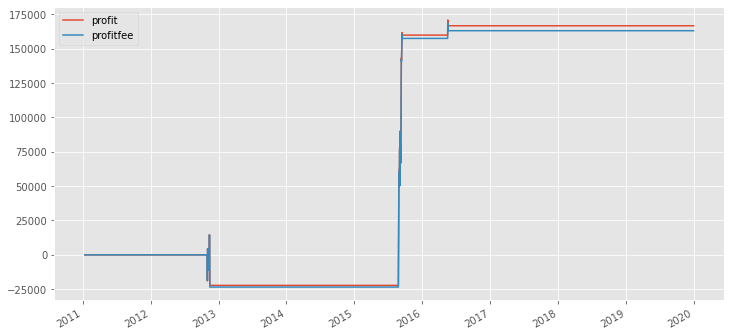

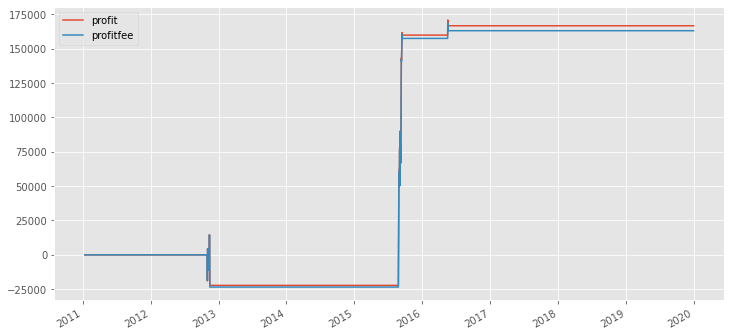

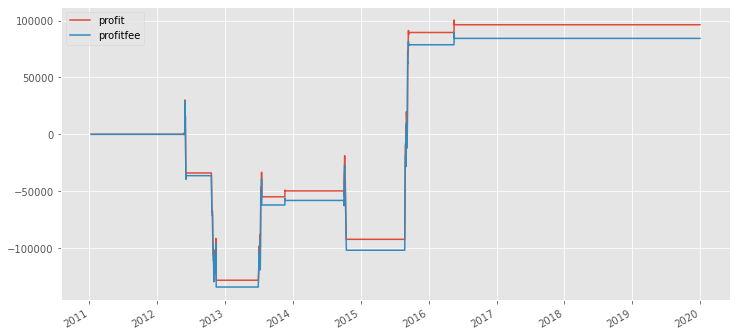

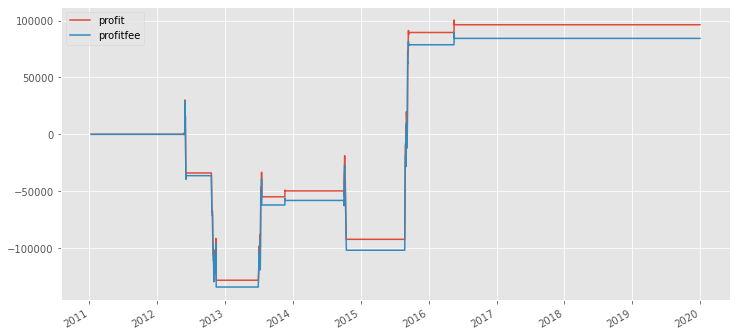

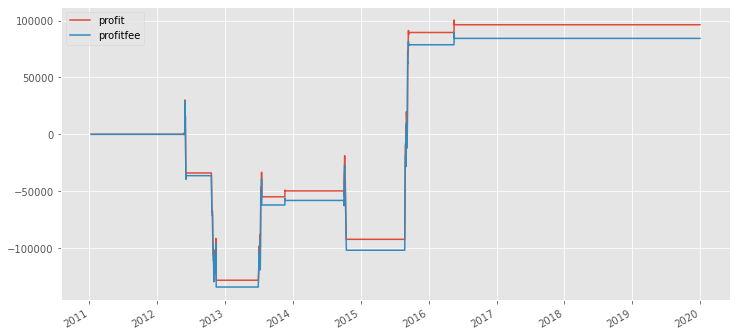

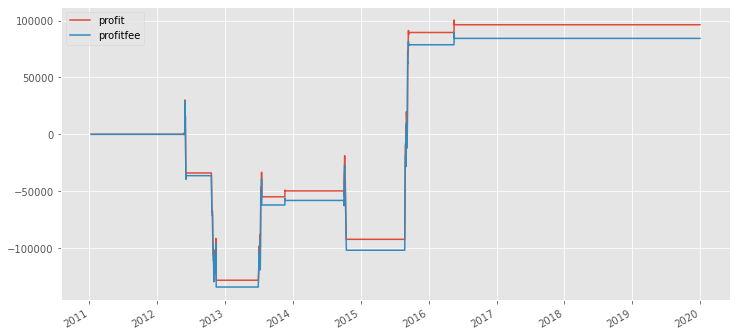

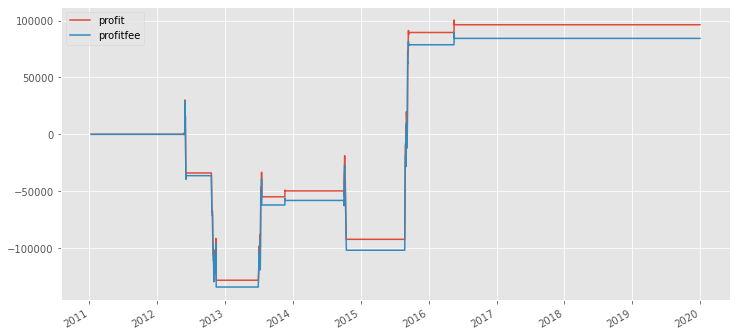

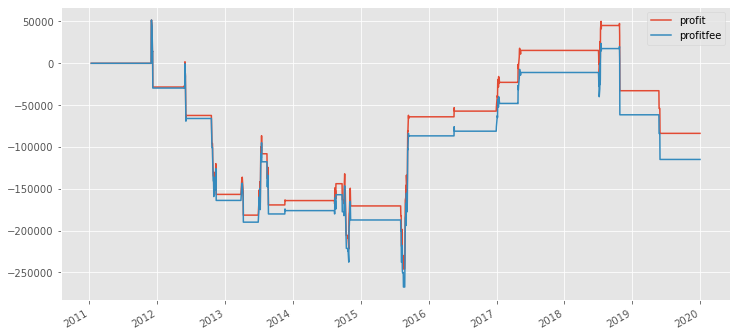

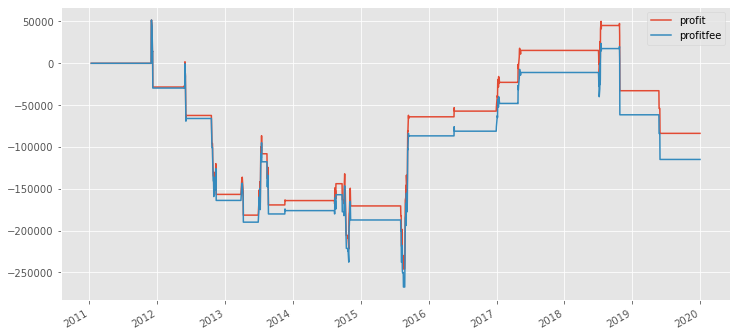

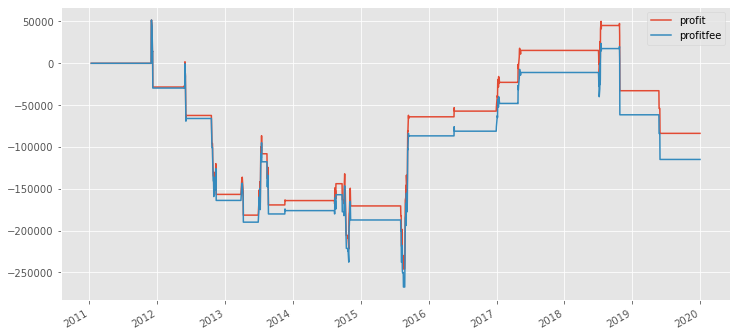

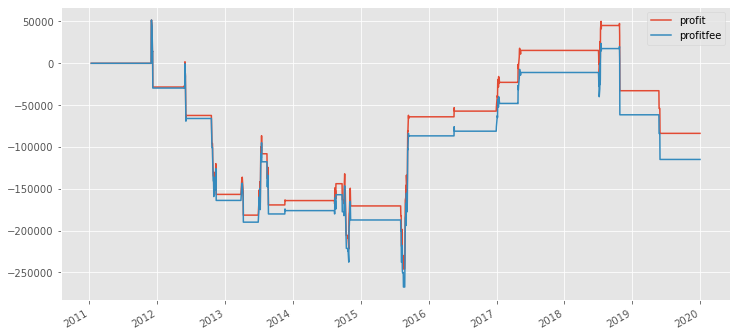

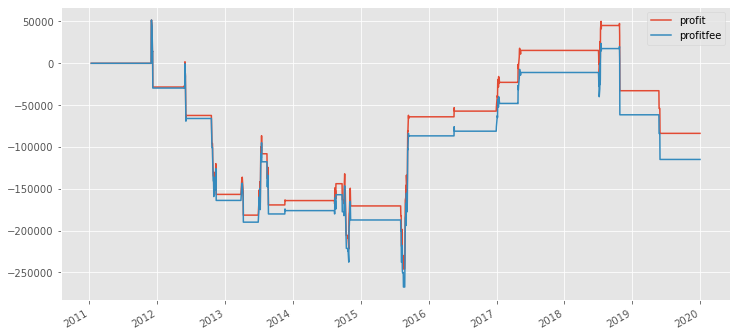

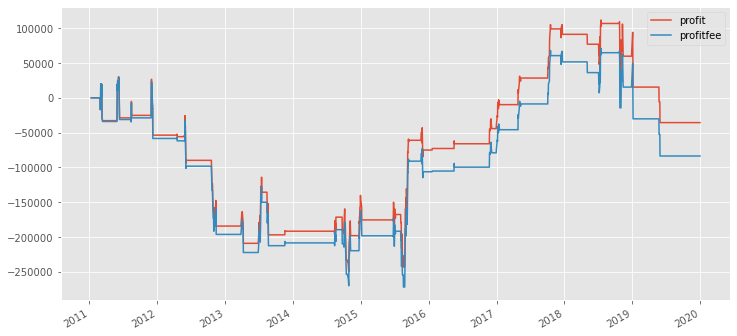

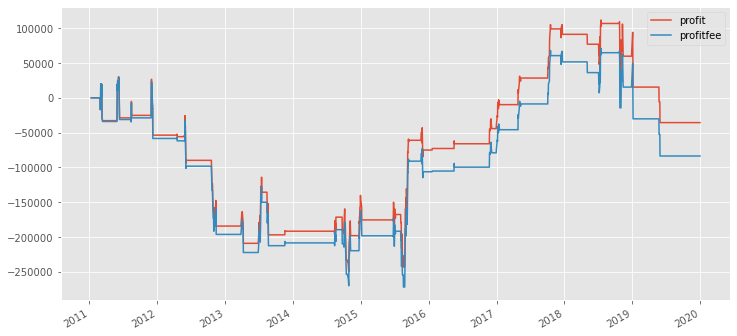

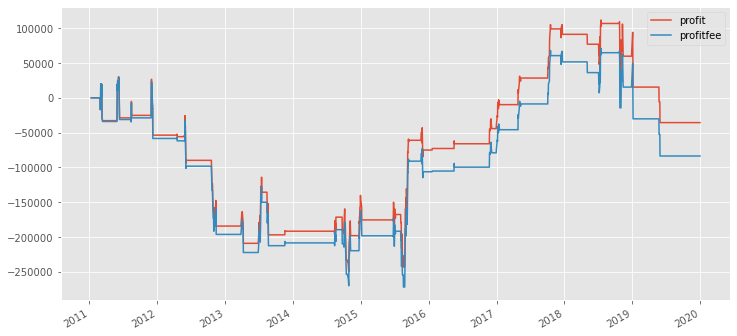

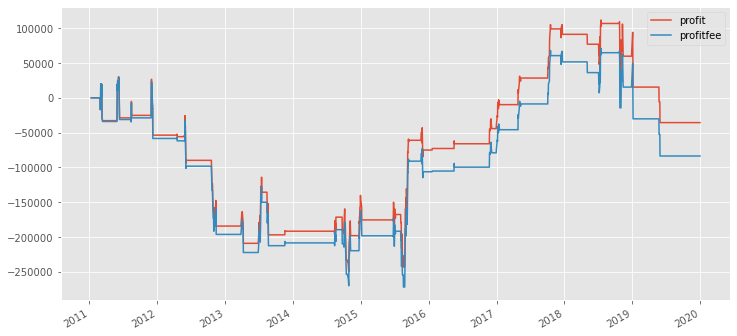

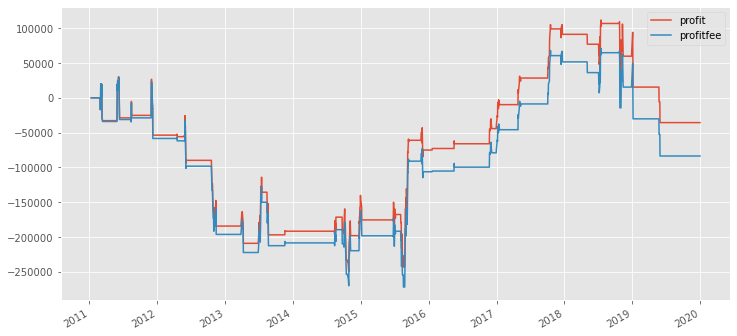

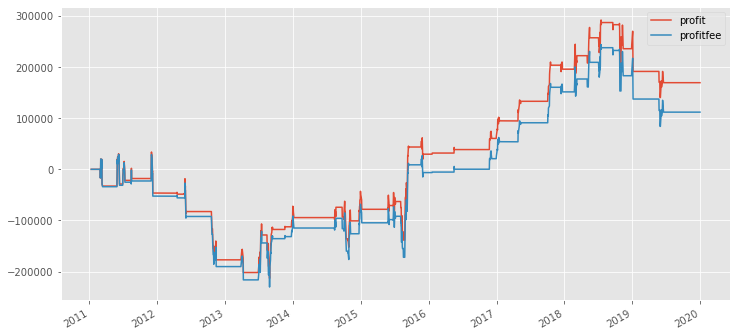

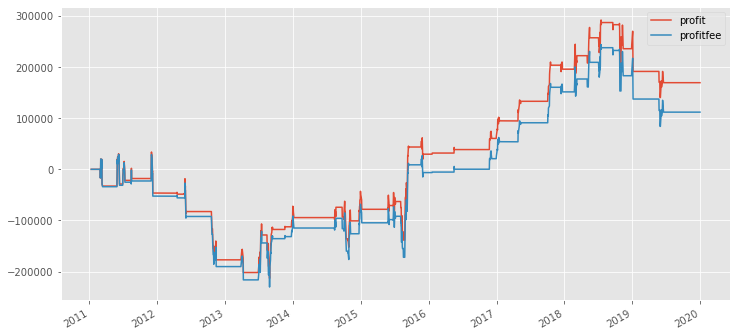

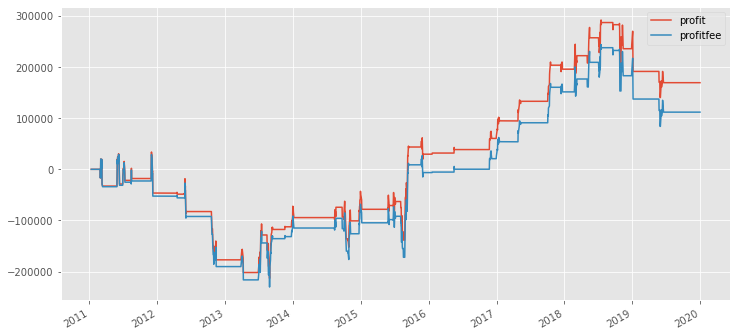

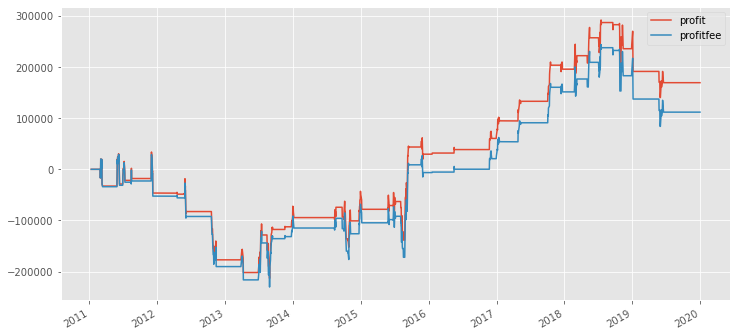

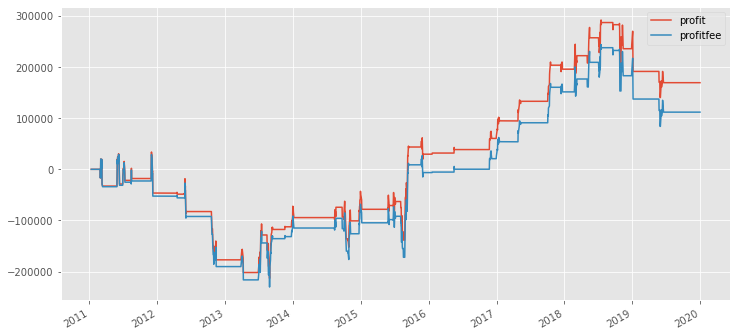

In [676]:
#以黃金交叉時K、D值需小於的可能值[15, 20, 25, 30, 35]，死亡交叉時需大於的可能[65, 70, 75, 80, 85]計算這25個組合下的結果，並挑選出最佳的組合
optimizationList = []
KD_l = [15, 20, 25, 30, 35]
KD_h = [65, 70, 75, 80, 85]
for KD_low in KD_l:
    for KD_high in KD_h:
        print('----------')
        print('KD_low:', KD_low)
        print('KD_high:', KD_high)


        BS = None
        buy = []
        sell = []
        sellshort = []
        buytocover = []
        profit_list = [0]
        profit_fee_list = [0]
        profit_fee_list_realized = []
        

        for i in range(len(df_arr)):
            
            if i == len(df_arr)-1:
                break
                
            ## 進場邏輯
            entryLong = df_arr[i-1, 7] < df_arr[i, 7] and df_arr[i, 5] < KD_low and df_arr[i, 6] < KD_low
            entrySellShort = df_arr[i-1, 7] > df_arr[i, 7] and df_arr[i, 5] > KD_high and df_arr[i, 6] > KD_high
            entryCondition = date_arr[i] not in settlementDate
            
            ## 出場邏輯
            exitShort = df_arr[i-1, 7] > df_arr[i, 7] and df_arr[i, 5] > 0.8 and df_arr[i, 6] > 0.8
            exitBuyToCover = df_arr[i-1, 7] < df_arr[i, 7] and df_arr[i, 5] < 0.2 and df_arr[i, 6] < 0.2
            exitCondition = date_arr[i] in settlementDate #and df_arr[i, 5] >= 11
            
            ## 停利停損邏輯
            if BS == 'B':
                stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
                stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
            elif BS == 'S':
                stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
                stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)


            if BS == None:
                profit_list.append(0)
                profit_fee_list.append(0)
                
                if entryLong and entryCondition:
                    BS = 'B'
                    t = i+1
                    buy.append(t)

                elif entrySellShort and entryCondition:
                    continue
                    BS = 'S'
                    t = i+1
                    sellshort.append(t)
            elif BS == 'B':
                profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
                profit_list.append(profit)
                    
                if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
                    pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
                    profit_fee = profit - feePaid*2
                    profit_fee_list.append(profit_fee)
                    sell.append(i+1)
                    BS=None
                    
                    # Realized PnL
                    profit_fee_realized = pl_round - feePaid*2
                    profit_fee_list_realized.append(profit_fee_realized)
                    
                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)
        '''    
            elif BS == 'S': 
                profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
                profit_list.append(profit)
                
                if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
                    pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
                    profit_fee = profit - feePaid*2
                    profit_fee_list.append(profit_fee)
                    buytocover.append(i+1)
                    BS=None
                    
                    # Realized PnL
                    profit_fee_realized = pl_round - feePaid*2
                    profit_fee_list_realized.append(profit_fee_realized)
        
                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)
        '''
        equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=trainData.index)
        equity.plot(grid=True, figsize=(12,6));
        equity['equity'] = equity['profitfee'] + fund
        equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
        equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
        ret = equity['equity'][-1]/equity['equity'][0] - 1
        mdd = abs(equity['drawdown_percent'].min())
        calmarRatio = ret / mdd
        print('ret:', ret)
        print('calmarRatio:', calmarRatio)
        print(stat(buy , sell ,sellshort, buytocover))
        optimizationList.append([KD_low, KD_high, ret, calmarRatio])


In [677]:
optResult = pd.DataFrame(optimizationList, columns=['KD_low','KD_high','ret','calmarRatio'])
optResult[optResult['KD_low']>=0.3]

,KD_low,KD_high,ret,calmarRatio
0,15,65,0.1630,4.352100
1,15,70,0.1630,4.352100
2,15,75,0.1630,4.352100
3,15,80,0.1630,4.352100
4,15,85,0.1630,4.352100
5,20,65,0.0844,0.531503
6,20,70,0.0844,0.531503
7,20,75,0.0844,0.531503
8,20,80,0.0844,0.531503
9,20,85,0.0844,0.531503


結果 : 考慮到交易的次數、績效以及calmarRatio，取KD_low = 30、KD_high = 70為最佳化後最佳的組合

以最佳化後的結果回測樣本外資料
=============

In [678]:
KD_low = 30
KD_high = 70

In [679]:
df_arr = np.array(testData)
time_arr = np.array(testData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

In [680]:
testData

,open,high,low,close,volume,K,D,trend
2020-01-14,12085.0,12174.0,12044.0,12172.0,137704,64.936793,54.978931,1
2020-01-15,12176.0,12199.0,12148.0,12175.0,108299,75.030903,61.662922,1
2020-01-16,12159.0,12175.0,12015.0,12036.0,109430,72.530562,65.285469,1
2020-01-17,12040.0,12104.0,11990.0,12097.0,138675,74.914133,68.495023,1
2020-01-18,12103.0,12118.0,12029.0,12106.0,117768,77.100790,71.363612,1
...,...,...,...,...,...,...,...,...
2022-05-17,15996.0,16044.0,15847.0,15919.0,153546,25.318781,21.833162,1
2022-05-18,15978.0,16189.0,15963.0,16184.0,125318,34.425854,26.030726,1
2022-05-19,16180.0,16318.0,15889.0,15902.0,125423,36.985657,29.682370,1
2022-05-20,15871.0,16054.0,15748.0,15999.0,224892,44.564512,34.643084,1


In [681]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

             profit  profitfee
2020-01-14      0.0        0.0
2020-01-15      0.0        0.0
2020-01-16      0.0        0.0
2020-01-17      0.0        0.0
2020-01-18      0.0        0.0
...             ...        ...
2022-05-17 -30600.0   -51000.0
2022-05-18 -34200.0   -54600.0
2022-05-19   6200.0   -15400.0
2022-05-20   6200.0   -15400.0
2022-05-21   6200.0   -15400.0

[571 rows x 2 columns]


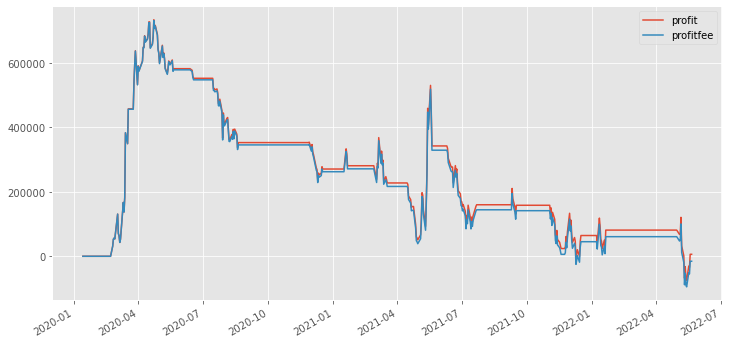

In [682]:
for i in range(len(df_arr)):
    
    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = df_arr[i-1, 7] < df_arr[i, 7] and df_arr[i, 5] < KD_low and df_arr[i, 6] < KD_low
    entrySellShort = df_arr[i-1, 7] > df_arr[i, 7] and df_arr[i, 5] > KD_high and df_arr[i, 6] > KD_high
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = df_arr[i-1, 7] > df_arr[i, 7] and df_arr[i, 5] > KD_high and df_arr[i, 6] > KD_high
    exitBuyToCover = df_arr[i-1, 7] < df_arr[i, 7] and df_arr[i, 5] < KD_low and df_arr[i, 6] < KD_low
    exitCondition = date_arr[i] in settlementDate
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            #continue
            BS = 'S'
            t = i+1
            sellshort.append(t)
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)
    
    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=testData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));

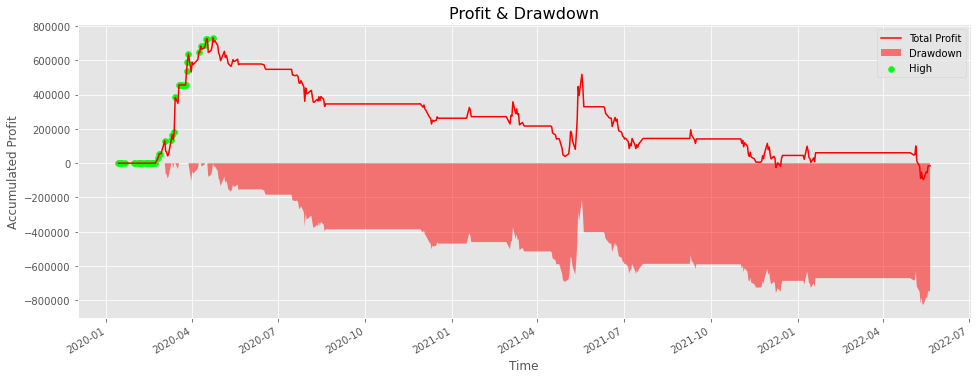

In [683]:
profit_and_drawdown()

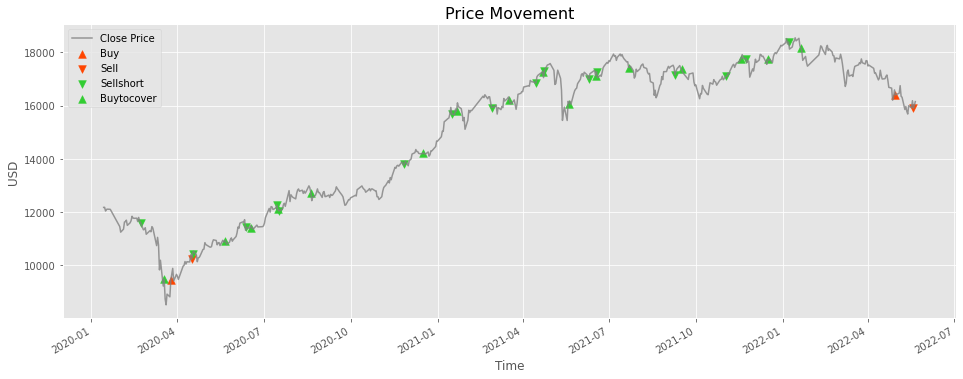

In [684]:
price_movement(testData)

In [685]:
stat(buy , sell ,sellshort, buytocover)

,buy,sell,sellshort,buytocover
0,2,2,16,16


結果 : 交易頻率偏低、且績效表現不佳

考慮到加濾網以後交易訊號會變少、且最佳化之後的結果可能會overfitting，這邊最後嘗試不加濾網對樣本外資料進行回測
=

In [686]:
df_arr = np.array(testData)
time_arr = np.array(testData.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]

In [687]:
testData

,open,high,low,close,volume,K,D,trend
2020-01-14,12085.0,12174.0,12044.0,12172.0,137704,64.936793,54.978931,1
2020-01-15,12176.0,12199.0,12148.0,12175.0,108299,75.030903,61.662922,1
2020-01-16,12159.0,12175.0,12015.0,12036.0,109430,72.530562,65.285469,1
2020-01-17,12040.0,12104.0,11990.0,12097.0,138675,74.914133,68.495023,1
2020-01-18,12103.0,12118.0,12029.0,12106.0,117768,77.100790,71.363612,1
...,...,...,...,...,...,...,...,...
2022-05-17,15996.0,16044.0,15847.0,15919.0,153546,25.318781,21.833162,1
2022-05-18,15978.0,16189.0,15963.0,16184.0,125318,34.425854,26.030726,1
2022-05-19,16180.0,16318.0,15889.0,15902.0,125423,36.985657,29.682370,1
2022-05-20,15871.0,16054.0,15748.0,15999.0,224892,44.564512,34.643084,1


In [688]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []

              profit  profitfee
2020-01-14       0.0        0.0
2020-01-15       0.0        0.0
2020-01-16       0.0        0.0
2020-01-17       0.0        0.0
2020-01-18       0.0        0.0
...              ...        ...
2022-05-17  428800.0   367600.0
2022-05-18  428800.0   367600.0
2022-05-19  428800.0   367600.0
2022-05-20  428800.0   367600.0
2022-05-21  428800.0   367600.0

[571 rows x 2 columns]


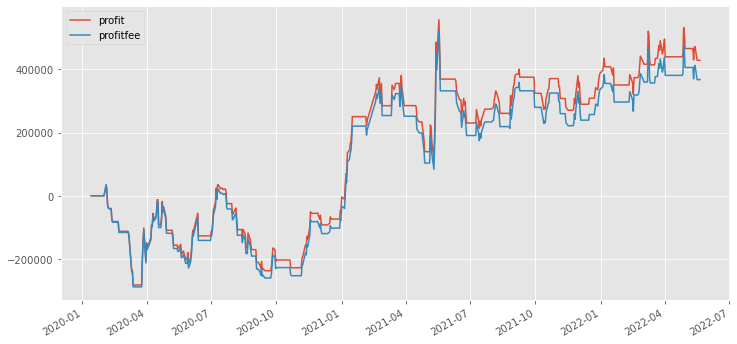

In [689]:
for i in range(len(df_arr)):
    
    if i == len(df_arr)-1:
        break
        
    ## 進場邏輯
    entryLong = df_arr[i-1, 7] < df_arr[i, 7] #and df_arr[i, 5] < 0.2 and df_arr[i, 6] < 0.2
    entrySellShort = df_arr[i-1, 7] > df_arr[i, 7] #and df_arr[i, 5] > 0.8 and df_arr[i, 6] > 0.8
    entryCondition = date_arr[i] not in settlementDate
    
    ## 出場邏輯
    exitShort = df_arr[i-1, 7] > df_arr[i, 7] #and df_arr[i, 5] > 0.8 and df_arr[i, 6] > 0.8
    exitBuyToCover = df_arr[i-1, 7] < df_arr[i, 7] #and df_arr[i, 5] < 0.2 and df_arr[i, 6] < 0.2
    exitCondition = date_arr[i] in settlementDate #and df_arr[i, 5] >= 11
    
    ## 停利停損邏輯
    if BS == 'B':
        stopLoss = df_arr[i,3] <= df_arr[t,0] * (1-K)
        stopProfit = df_arr[i,3] >= df_arr[t,0] * (1+K)
    elif BS == 'S':
        stopLoss = df_arr[i,3] >= df_arr[t,0] * (1+K)
        stopProfit = df_arr[i,3] <= df_arr[t,0] * (1-K)

#     if exitCondition == True:
#         print(f'{time_arr[i]}')

    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)
        
        if entryLong and entryCondition:
            BS = 'B'
            t = i+1
            buy.append(t)

        elif entrySellShort and entryCondition:
            #continue
            BS = 'S'
            t = i+1
            sellshort.append(t)
    elif BS == 'B':
        profit = 200 * (df_arr[i+1,0] - df_arr[i,0])
        profit_list.append(profit)
            
        if exitShort or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[i+1,0] - df_arr[t,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
             
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif BS == 'S': 
        profit = 200 * (df_arr[i,0] - df_arr[i+1,0])
        profit_list.append(profit)
        
        if exitBuyToCover or i == len(df_arr)-2 or exitCondition or stopLoss or stopProfit:
            pl_round = 200 * (df_arr[t,0] - df_arr[i+1,0])
            profit_fee = profit - feePaid*2
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS=None
            
            # Realized PnL
            profit_fee_realized = pl_round - feePaid*2
            profit_fee_list_realized.append(profit_fee_realized)
 
        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=testData.index)
print(equity)
equity.plot(grid=True, figsize=(12,6));
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd

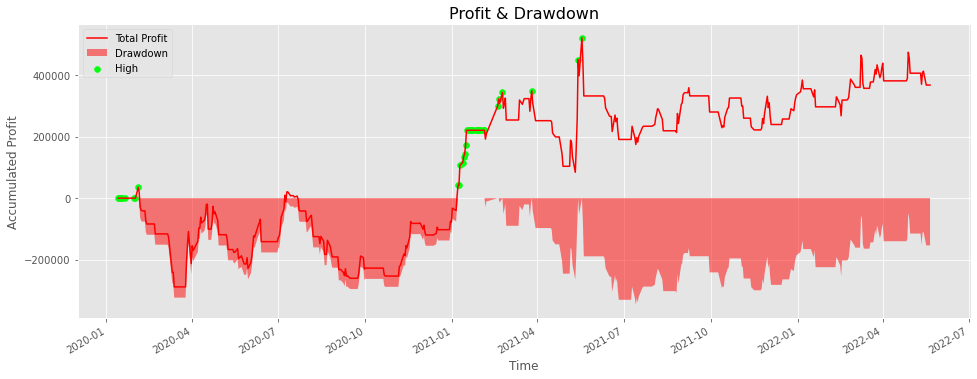

In [690]:
profit_and_drawdown()

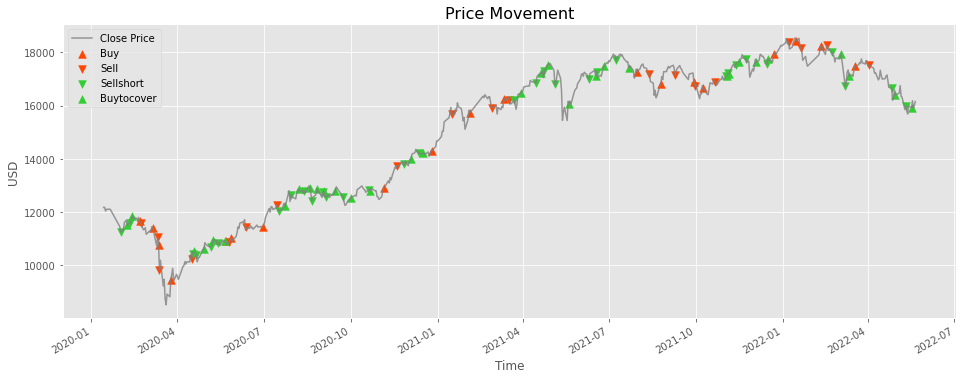

In [691]:
price_movement(testData)

In [692]:
stat(buy , sell ,sellshort, buytocover)

,buy,sell,sellshort,buytocover
0,19,19,32,32


In [693]:
print('ret : ', ret)
print('mdd :', mdd)
print('calmarRatio :', calmarRatio)

ret :  0.3675999999999999
mdd : 0.312463768115942
calmarRatio :  1.1764564007421148


結果 : 可看出在樣本外資料這兩年半的期間，其報酬率為36.75%，最大交易回落(MDD)為0.31、calmarRatio為1.1765